Figures for Maximov MA, Galukhin AV and Gor GY, "Pore Size Distribution of Silica Colloidal Crystals from Nitrogen Adsorption Isotherms", Langmuir 2019
========

In [1]:
%run __imports.ipynb
from CoolProp.CoolProp import PropsSI as props
import math

In [2]:
# BET limits
pressure_limit_min = 0.05
pressure_limit_max = 0.305
n2_csa = 0.162e-18  # m^2
sigma = 0.36154e-9  # m
pore_sizes = np.arange(1, 200, 2)

Figure 4: Experimental isotherms

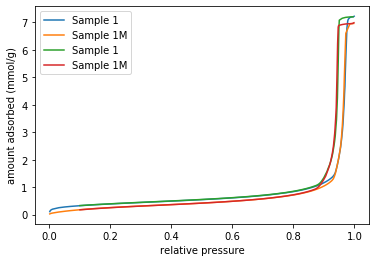

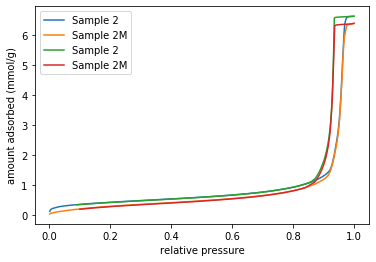

In [3]:
for sample_idx in [1, 2]:
    for branch in ["ads", "des"]:
        for modification in ["", "M"]:
            sample_id = f"{sample_idx}{modification}"
            data = np.genfromtxt(f"../data/maximov2019lang/sample{sample_id}-{branch}.tsv", names=True)
            pressure = data["p_rel"]
            density = data["Q_cm3_per_g_STP"] / (dbdb.V_m * 1e3)
            plt.plot(pressure, density, "-", label=f"Sample {sample_id}")
            plt.legend()
            plt.xlabel("relative pressure")
            plt.ylabel("amount adsorbed (mmol/g)")
    plt.show()

Figure 5: FHH fit of reference isotherms

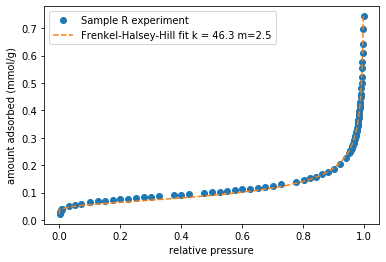

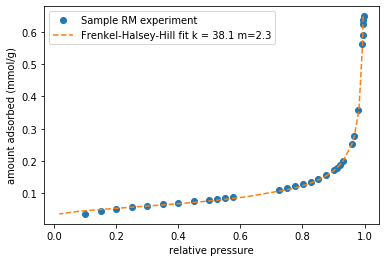

In [4]:
for ref_id in ["R", "RM"]:
    data = np.genfromtxt(f"../data/maximov2019lang/sample{ref_id}.tsv", names=True)
    pressure = data["p_rel"]
    density = data["Q_cm3_per_g_STP"] / (dbdb.V_m * 1e3)
    surface_area = bet.surface_area(pressure, density, csa=n2_csa, pressure_limit_min=pressure_limit_min,
                           pressure_limit_max=pressure_limit_max) * 1e3
    model = dbdb.nitrogen(reference_s_a=surface_area)
    fhh_k, fhh_m = model.fhh_fit(pressure, density)

    plt.plot(pressure, density, "o", label=f"Sample {ref_id} experiment")
    plt.plot(
        model.relative_pressure_macropore(density, fhh_k, fhh_m),
        density,
        "--",
        label=f"Frenkel-Halsey-Hill fit k = {fhh_k:.1f} m={fhh_m:.1f}",
    )
    plt.legend()
    plt.xlabel("relative pressure")
    plt.ylabel("amount adsorbed (mmol/g)")
    plt.show()

Figure 6: Kernel

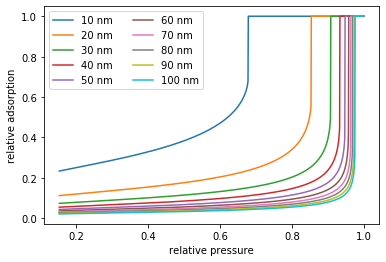

In [5]:
ref_id = "RM"
is_ads_branch = True
data = np.genfromtxt(f"../data/maximov2019lang/sample{ref_id}.tsv", names=True)
pressure = data["p_rel"]
density = data["Q_cm3_per_g_STP"] / (dbdb.V_m * 1e3)
surface_area = bet.surface_area(pressure, density, csa=n2_csa, pressure_limit_min=pressure_limit_min,
                       pressure_limit_max=pressure_limit_max) * 1e3
model = dbdb.nitrogen(reference_s_a=surface_area)

fhh_k, fhh_m = model.fhh_fit(pressure, density)

p_monolayer = model.relative_pressure(h=sigma, fhh_k=fhh_k, fhh_m=fhh_m, r=1e100)  # infinite radius
pressure = np.linspace(p_monolayer, 1, 1001)
kernel = model.kernel(pressure, pore_sizes, fhh_k, fhh_m, is_ads_branch=is_ads_branch)

display_pores_sizes = pore_sizes if len(pore_sizes) < 5 else np.arange(10, 100 + 10, 10)
for d in display_pores_sizes:
    psz_idx = np.abs(pore_sizes - d).argmin()
    plt.plot(pressure, kernel[:, psz_idx], "-", label=f"{d} nm")

plt.xlabel("relative pressure")
plt.ylabel("relative adsorption")
plt.legend(ncol=2)
plt.show()

Figure 7: Pore-Size Distribution and Figure 8: Solution

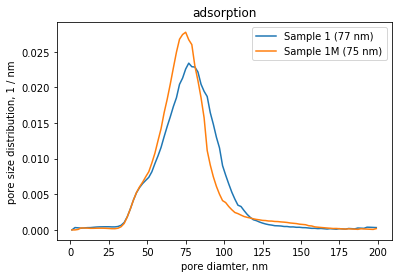

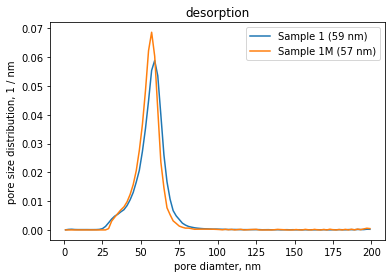

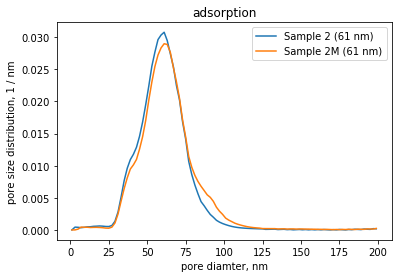

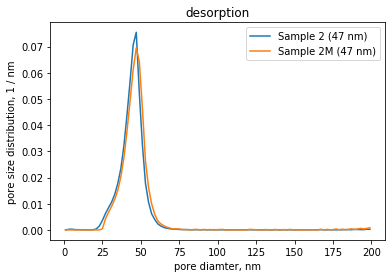

In [6]:
def interpolate(p, n):
    min_p = np.min(p)
    max_p = np.max(p)
    min_step = np.min(np.diff(p))
    p_interp = np.arange(min_p, max_p + min_step, min_step)
    n_interp = scipy.interpolate.interp1d(p, n, fill_value="extrapolate")(p_interp)
    return p_interp, n_interp

def normalize(y, x):
    return y / scipy.integrate.trapz(y, x)

def Dlin_to_Dlog(D, r):
    return D * r / math.log(math.exp(1.0), 10)


for sample_idx in [1, 2]:
    for is_ads_branch in [True, False]:
        for modification in ["", "M"]:
            ref_id = f"R{modification}"
            sample_id = f"{sample_idx}{modification}"
            branch = "ads" if is_ads_branch else "des"
            
            # reference sample data
            data = np.genfromtxt(f"../data/maximov2019lang/sample{ref_id}.tsv", names=True)
            pressure_ref = data["p_rel"]
            density_ref = data["Q_cm3_per_g_STP"] / (dbdb.V_m * 1e3)
            surface_area = bet.surface_area(pressure_ref, density_ref, csa=n2_csa, pressure_limit_min=pressure_limit_min,
                                   pressure_limit_max=pressure_limit_max) * 1e3

            # target experimental mesoporous isotherm
            data = np.genfromtxt(f"../data/maximov2019lang/sample{sample_id}-{branch}.tsv", names=True)
            data.sort(order="p_rel")
            pressure_exp = data["p_rel"]
            density_exp = data["Q_cm3_per_g_STP"] / (dbdb.V_m * 1e3)
            pressure_exp, density_exp = interpolate(pressure_exp, density_exp)
            
            model = dbdb.nitrogen(reference_s_a=surface_area)
            fhh_k, fhh_m = model.fhh_fit(pressure_ref, density_ref)

            # kernel and solution
            alpha = np.concatenate(([1e-7], np.linspace(0, 1e4, 1001)[1:]))
            kernel = model.kernel(pressure_exp, pore_sizes, fhh_k, fhh_m, is_ads_branch=is_ads_branch)
            clf_nnls = RidgeNNLS(alphas=np.power(alpha, 2)).fit(kernel, density_exp, alpha=8)
            psd_ridge_nnls = clf_nnls.coef_
            psd_ridge_nnls = Dlin_to_Dlog(psd_ridge_nnls, pore_sizes)
            d_max = pore_sizes[psd_ridge_nnls.argmax()]
            
            # save kernel on disk
            np.savetxt(f"../data/maximov2019lang/kernel_{ref_id}_{branch}.tsv", kernel)
            np.savetxt(f"../data/maximov2019lang/kernel_{ref_id}_{branch}_pressures.tsv", pressure_exp)
            np.savetxt("../data/maximov2019lang/kernel_pore_sizes.tsv", pore_sizes)

            plt.plot(pore_sizes, normalize(psd_ridge_nnls, pore_sizes), "-", label=f"Sample {sample_id} ({d_max} nm)")
            plt.xlabel("pore diamter, nm")
            plt.ylabel("pore size distribution, 1 / nm")
            plt.title(f"{branch}orption")
            plt.legend()
        plt.show()

Example use of a saved kernel

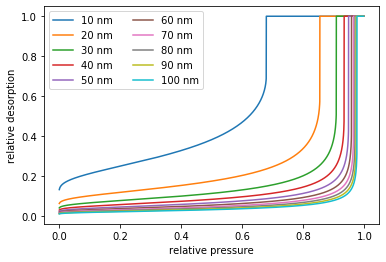

,d = 1.0 nm,d = 3.0 nm,d = 5.0 nm,d = 7.0 nm,d = 9.0 nm,...,d = 191.0 nm,d = 193.0 nm,d = 195.0 nm,d = 197.0 nm,d = 199.0 nm
p/p0 = 0.00,1.0,0.376056,0.234857,0.170651,0.133994,...,0.006515,0.006446,0.006381,0.006316,0.006252
p/p0 = 0.00,1.0,0.383369,0.239489,0.174041,0.136666,...,0.006645,0.006577,0.006511,0.006443,0.006379
p/p0 = 0.00,1.0,0.389275,0.243226,0.176774,0.138821,...,0.006752,0.006683,0.006614,0.006546,0.006481
p/p0 = 0.00,1.0,0.394283,0.246391,0.179089,0.140645,...,0.006842,0.006771,0.006703,0.006634,0.006567
p/p0 = 0.00,1.0,0.398663,0.249157,0.181111,0.142239,...,0.006921,0.006849,0.006779,0.006711,0.006642
...,...,...,...,...,...,...,...,...,...,...,...
p/p0 = 1.00,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000
p/p0 = 1.00,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000
p/p0 = 1.00,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000
p/p0 = 1.00,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
pore_sizes = np.loadtxt("../data/maximov2019lang/kernel_pore_sizes.tsv")
pressure_exp = np.loadtxt("../data/maximov2019lang/kernel_RM_ads_pressures.tsv")
kernel = np.loadtxt(f"../data/maximov2019lang/kernel_RM_ads.tsv")

display_pores_sizes = pore_sizes if len(pore_sizes) < 5 else np.arange(10, 110, 10)
for d in display_pores_sizes:
    psz_idx = np.abs(pore_sizes - d).argmin()
    plt.plot(pressure_exp, kernel[:, psz_idx], "-", label=f"{d} nm")

plt.legend(ncol=2)
plt.xlabel("relative pressure")
plt.ylabel("relative desorption")
plt.show()

df = pd.DataFrame(kernel)
df.columns = [f"d = {d} nm" for d in pore_sizes]
df.index = [f"p/p0 = {d:.2f}" for d in pressure_exp]
df